# Optimised Portfolio Construction using Capital Asset Pricing Model, Quadratic Programming, and Sharpe Ratio

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import yfinance as fy
import statsmodels.api as sm
from cvxopt import matrix, solvers
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

In [2]:
# 10 Stocks price value and their market index values (Yahoo Finance Data)

stocks = ["AAPL", "MSFT", "TSLA", "GOOG", "AMZN", "JPM", "JNJ", "XOM", "NVDA", "WMT"]
market_index = "^GSPC"  # S&P 500

# Defining time-periods (Last 5 Years of Data)

start_date = '2020-03-01'
end_date = '2025-03-01'

# Downloading closing stock prices for 10 assets and market index data with auto-adjusted closing values

stock_data = fy.download(stocks, start=start_date, end=end_date)['Close']
market_data = fy.download(market_index, start=start_date, end=end_date)["Close"]

# Computing daily returns for stocks and market index

stock_returns = stock_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

stock_returns.to_csv('Stock_Returns.csv')
market_returns.to_csv('Market_Returns.csv')

print(stock_returns.head())
print(market_returns.head())

YF.download() has changed argument auto_adjust default to True




*********************100%***********************]  1 of 1 completedd

Ticker          AAPL      AMZN      GOOG       JNJ       JPM      MSFT  \
Date                                                                     
2020-03-03 -0.031759 -0.023010 -0.034353 -0.031638 -0.037525 -0.047919   
2020-03-04  0.046384  0.035013  0.033644  0.058190  0.024709  0.036715   
2020-03-05 -0.032437 -0.026217 -0.048669 -0.010245 -0.049061 -0.025095   
2020-03-06 -0.013280 -0.011923 -0.015640  0.000141 -0.051680 -0.028267   
2020-03-09 -0.079092 -0.052854 -0.063809 -0.039358 -0.135455 -0.067772   

Ticker          NVDA      TSLA       WMT       XOM  
Date                                                
2020-03-03 -0.038129  0.002542 -0.025630 -0.047884  
2020-03-04  0.070029  0.005352  0.034186  0.021832  
2020-03-05 -0.039436 -0.033302 -0.007279 -0.044067  
2020-03-06 -0.026529 -0.029067  0.011301 -0.048294  
2020-03-09 -0.077432 -0.135725 -0.000597 -0.122248  
Ticker         ^GSPC
Date                
2020-03-03 -0.028108
2020-03-04  0.042203
2020-03-05 -0.033922
2020-

## Linear Regression for expected returns and risks

In [3]:
# Storing market returns name

market_col = market_returns.columns[0]

# Risk-free rate has been given as 0.02

RF = 0.02

# Computing excess returns (Ri - Rf) (Stock returns - Risk-free rates)

excess_stock_returns = stock_returns - RF
excess_market_returns = market_returns - RF

# Initializing dictionary for coefficient

alpha_coeff = {}
beta_coeff = {}
expected_returns = {}
idiosyncratic_variance = {}

# Performing CAPM regression for each stock

for stock in stock_returns.columns:
    # x: independent variable (market excess return)
    x = excess_market_returns
    # y: dependent variable (stock excess return)
    y = excess_stock_returns[stock]


    # Adding intercept (Alpha) for regression
    x = sm.add_constant(x)

    # Performing OLS regression
    model = sm.OLS(y, x).fit()

    # Extracting regression coefficients
    alpha = model.params['const']
    beta = model.params[market_col]

    # Computing expected return using CAPM
    expected_return = RF + beta * (market_returns.mean().values[0] - RF)

    # Computing idiosyncratic risk (variance of residuals)
    residuals = model.resid
    idiosyncratic_var = np.var(residuals)

    # Storing results
    alpha_coeff[stock] = alpha
    beta_coeff[stock] = beta
    expected_returns[stock] = expected_return
    idiosyncratic_variance[stock] = idiosyncratic_var


capm = pd.DataFrame({'Alpha': alpha_coeff, 
                          'Beta': beta_coeff,
                          'Expected_Return': expected_returns,
                          'Idiosyncratic_Variance_Assets_Risk': idiosyncratic_variance})
capm

,Alpha,Beta,Expected_Return,Idiosyncratic_Variance_Assets_Risk
AAPL,0.003453,1.150126,-0.002300,0.000154
AMZN,0.002140,1.096914,-0.001268,0.000296
GOOG,0.002954,1.135640,-0.002019,0.000190
JNJ,-0.010658,0.465369,0.010977,0.000116
JPM,0.001786,1.075118,-0.000845,0.000211
MSFT,0.003515,1.167496,-0.002636,0.000121
NVDA,0.017784,1.799273,-0.014886,0.000611
TSLA,0.012735,1.571727,-0.010474,0.001261
WMT,-0.010300,0.453459,0.011208,0.000166
XOM,-0.003268,0.811579,0.004264,0.000343


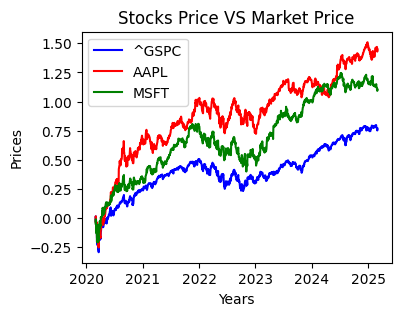

In [18]:
plt.figure(figsize = (4, 3))
plt.plot(market_returns.cumsum(), c='blue')
plt.plot(stock_returns['AAPL'].cumsum(), c = 'red')
plt.plot(stock_returns['MSFT'].cumsum(), c = 'green')
plt.legend(['^GSPC', 'AAPL', 'MSFT'])
plt.xlabel('Years')
plt.ylabel('Prices')
plt.title('Stocks Price VS Market Price')
plt.savefig('Stocks Price VS Market Price.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Portfolio Optimisation formulated as Quadratic Programming

### Minimising risk using Quadratic Programming optimisation method

In [5]:
# Storing required column values

expected_returns = capm['Expected_Return'].values
betas = capm['Beta'].values
idiosyncratic_var = capm['Idiosyncratic_Variance_Assets_Risk'].values

# Computing market variance

market_variance = np.var(market_returns.values)

# Total stock counts

n = len(expected_returns)

# Computing covariance martix

cov_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            cov_matrix[i, j] = (betas[i]**2)*market_variance+idiosyncratic_var[i]
        else:
            cov_matrix[i, j] = betas[i] * betas[j] * market_variance
        
# Converting to cvxopt matrix

P = matrix(cov_matrix) # Quadratic term
Q = matrix(np.zeros(n)) # Linear term

# Use average expected return as a target return

target_return = np.mean(expected_returns)

# Constraints

A = matrix(np.vstack([expected_returns, np.ones(n)])) # Enforces target return and sum to 1
B = matrix(np.array([target_return, 1])) # Example target retun
G = matrix(-np.identity(n)) # Non-negative weights
H = matrix(np.zeros(n)) 

# Solver Quadratic Program

solvers.options['show_progress'] = False
solution = solvers.qp(P, Q, G, H, A, B)

# Extracting optimal weights

optimal_weights = np.array(solution['x']).flatten()

portfolio_weights = pd.DataFrame({'Stock': capm.index, 'Weights': np.round(optimal_weights, 4)})

portfolio_weights.to_csv('Portfolio Weights.csv')

portfolio_weights

,Stock,Weights
0,AAPL,0.1651
1,AMZN,0.0817
2,GOOG,0.1316
3,JNJ,0.0885
4,JPM,0.1126
5,MSFT,0.2136
6,NVDA,0.0651
7,TSLA,0.0284
8,WMT,0.0607
9,XOM,0.0527


## Efficient Frontier

In [6]:
# Defining target returns (10 values: Equally Spaced)

target_returns = np.linspace(min(expected_returns), max(expected_returns), 10)

# Initialising lists for efficient frontier points

portfolio_risks = []
portfolio_returns = []

# Previously computed P and Q value

P = matrix(cov_matrix) # Quadratic term
Q = matrix(np.zeros(n))

# Solving for each target return

for target_return in target_returns:
    A = matrix(np.vstack([expected_returns, np.ones(n)]))  # Constraints (returns & sum-to-1)
    B = matrix(np.array([target_return, 1]))  # Target return and sum constraint
    G = matrix(-np.identity(n))  # No short-selling constraint
    H = matrix(np.zeros(n))

    # Solving Quadratic Program
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, Q, G, H, A, B)

    # Extracting optimal weights
    optimal_weights = np.array(solution['x']).flatten()

    # Computing portfolio risk (Standard Deviation)
    portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)

    # Storing results
    portfolio_risks.append(portfolio_std_dev)
    portfolio_returns.append(target_return)

efficient_frontier = pd.DataFrame({'Portfolio Risks': portfolio_risks, 'Portfolio Returns': portfolio_returns, })

efficient_frontier.to_csv('Efficient Frontier.csv')

efficient_frontier

,Portfolio Risks,Portfolio Returns
0,0.034394,-0.014886
1,0.027941,-0.011987
2,0.023491,-0.009087
3,0.019728,-0.006188
4,0.016937,-0.003289
5,0.014768,-0.000389
6,0.012831,0.002510
7,0.011252,0.005409
8,0.010279,0.008309
9,0.014238,0.011208


## Trade-off between Risk and Return

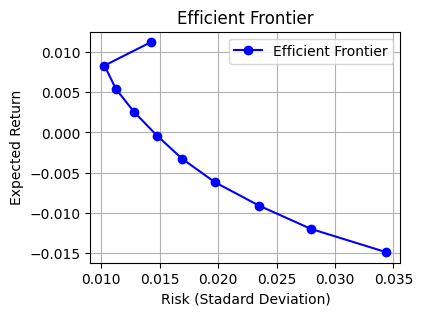

In [7]:
plt.figure(figsize=(4, 3))
plt.plot(efficient_frontier['Portfolio Risks'], efficient_frontier['Portfolio Returns'], marker='o', linestyle='-', color='b', label='Efficient Frontier')
plt.xlabel('Risk (Stadard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.savefig('Efficient Frontier QP.png', dpi=300, bbox_inches='tight')
plt.show()

# Important Changes - Increasing max expected return

In [8]:
# Defining target returns (10 values: Equally Spaced)

target_returns = np.linspace(min(expected_returns), max(expected_returns)*1.5, 10)

# Initialising lists for efficient frontier points
portfolio_risks = []
portfolio_returns = []

# Previously computed P and Q value

P = matrix(cov_matrix) # Quadratic term
Q = matrix(np.zeros(n))

# Solving for each target return

for target_return in target_returns:
    A = matrix(np.vstack([expected_returns, np.ones(n)]))  # Constraints (returns & sum-to-1)
    B = matrix(np.array([target_return, 1]))  # Target return and sum constraint
    G = matrix(-np.identity(n))  # No short-selling constraint
    H = matrix(np.zeros(n))

    # Solving Quadratic Program
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, Q, G, H, A, B)

    # Extracting optimal weights
    optimal_weights = np.array(solution['x']).flatten()

    # Computing portfolio risk (Standard Deviation)
    portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)

    # Storing results
    portfolio_risks.append(portfolio_std_dev)
    portfolio_returns.append(target_return)

efficient_frontier = pd.DataFrame({'Portfolio Risks': portfolio_risks, 'Portfolio Returns': portfolio_returns})

efficient_frontier.to_csv('Efficient Frontier Ex_tr.csv')

efficient_frontier

,Portfolio Risks,Portfolio Returns
0,0.034394,-0.014886
1,0.026939,-0.011364
2,0.021778,-0.007842
3,0.017803,-0.004320
4,0.015062,-0.000798
5,0.012701,0.002724
6,0.010896,0.006246
7,0.010100,0.009768
8,0.015638,0.013290
9,0.046125,0.016812


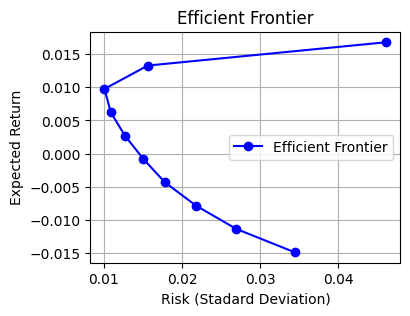

In [9]:
plt.figure(figsize=(4, 3))
plt.plot(efficient_frontier['Portfolio Risks'], efficient_frontier['Portfolio Returns'], marker='o', linestyle='-', color='b', label='Efficient Frontier')
plt.xlabel('Risk (Stadard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.savefig('Efficient Frontier Ex_tr.png', dpi=300, bbox_inches='tight')
plt.show()

## Further optimising stocks portfolio weights using Negative Sharpe Ratio method

In [10]:
RF = 0.0045
cov_matrix = cov_matrix
expected_returns = capm['Expected_Return']
n_assets = len(expected_returns)
init_weights = portfolio_weights['Weights']
target_returns = np.linspace(min(expected_returns)*1.5, max(expected_returns)*2.3, 10)

def calculate_portfolio(tr, er, cov_matrix, n_assets, rf=RF, init_weights=init_weights):
    # Objective function to minimize (negative Sharpe ratio)
    def negative_sharpe_ratio(weights):
        port_return = np.dot(weights, er)  # Portfolio return
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio risk
        return -(port_return - rf) / port_risk  # Negative Sharpe ratio

    # Constraints: sum of weights = 1 (full investment) and target return = portfolio return
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, er) - tr}  
    )
    # Bounds (Short-Selling Restriction & Diversification)
    bounds = [(-0.2, 1.0)] * n_assets  # No short-selling & max per stock
    
    # Solve the optimization problem
    result = minimize(negative_sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Return the portfolio return and risk for the optimal weights
    o_w = result.x
    port_return = np.dot(o_w, er)
    port_risk = np.sqrt(np.dot(o_w.T, np.dot(cov_matrix, o_w)))
    return port_return, port_risk

# Calculate efficient frontier
portfolio_risks_1 = []
portfolio_returns_1 = []
for target_return in target_returns:
    port_return, port_risk = calculate_portfolio(target_return, expected_returns, cov_matrix, n_assets)
    portfolio_risks_1.append(port_risk)
    portfolio_returns_1.append(port_return)

# Store in DataFrame
efficient_frontier_1 = pd.DataFrame({'Portfolio Risk': portfolio_risks_1, 'Portfolio Return': portfolio_returns_1})

efficient_frontier_1.to_csv('Efficient Frontier NS.csv')

efficient_frontier_1

C:\Users\ELCOT\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\ELCOT\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\ELCOT\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


,Portfolio Risk,Portfolio Return
0,0.052617,-0.022329
1,0.049139,-0.016984
2,0.045983,-0.011638
3,0.043634,-0.006293
4,0.041272,-0.000948
5,0.015734,0.004397
6,0.009903,0.009743
7,0.010493,0.015088
8,0.013198,0.020433
9,0.017139,0.025778


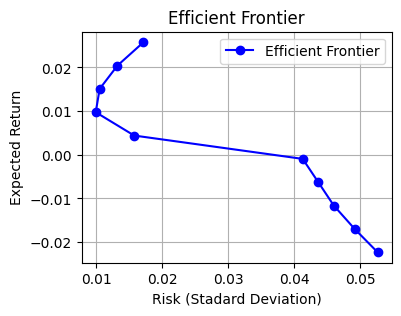

In [11]:
plt.figure(figsize=(4, 3))
plt.plot(portfolio_risks_1, portfolio_returns_1, marker='o', linestyle='-', color='b', label='Efficient Frontier')
plt.xlabel('Risk (Stadard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.savefig('Efficient Frontier NS', dpi=300, bbox_inches='tight')
plt.show()

## Portfolio's Performance

In [12]:
# Calculate Sharpe Ratio for each portfolio
sharpe = efficient_frontier_1
sharpe["Sharpe Ratio"] = (sharpe["Portfolio Return"] - RF) / sharpe["Portfolio Risk"]

# Identifying key portfolios
equal_weighted = sharpe.iloc[5]  # Mid-range portfolio as a proxy for equal-weighted
min_variance = sharpe.iloc[sharpe["Portfolio Risk"].idxmin()]  # Minimum risk portfolio
max_sharpe = sharpe.iloc[sharpe["Sharpe Ratio"].idxmax()]  # Maximum Sharpe ratio portfolio

# Creating the final performance table
portfolio_performance = pd.DataFrame({
    "Portfolio Strategy": ["Equal-Weighted Portfolio", "Minimum Variance Portfolio", "Optimized Sharpe Portfolio"],
    "Expected Return%": [equal_weighted["Portfolio Return"], min_variance["Portfolio Return"], max_sharpe["Portfolio Return"]],
    "Risk% (Volatility)": [equal_weighted["Portfolio Risk"], min_variance["Portfolio Risk"], max_sharpe["Portfolio Risk"]],
    "Sharpe Ratio": [equal_weighted["Sharpe Ratio"], min_variance["Sharpe Ratio"], max_sharpe["Sharpe Ratio"]]
})

# Convert percentages
portfolio_performance["Expected Return%"] *= 100
portfolio_performance["Risk% (Volatility)"] *= 100

portfolio_performance.to_csv('Portfolio Performance.csv')

# Display results
portfolio_performance


,Portfolio Strategy,Expected Return%,Risk% (Volatility),Sharpe Ratio
0,Equal-Weighted Portfolio,0.439731,1.573350,-0.006527
1,Minimum Variance Portfolio,0.974255,0.990285,0.529398
2,Optimized Sharpe Portfolio,2.577826,1.713856,1.241543


# Ranking Assets basd on Expected Return, Beta, and Portfolio Weights

In [13]:
# Merge CAPM results with portfolio weights

merged_data = capm.merge(portfolio_weights, left_index=True, right_on="Stock")

# Rename Portfolio Weight column for clarity

merged_data.rename(columns={"Weights": "Portfolio_Weight"}, inplace=True)

# Rank stocks based on:

merged_data["Rank_Expected_Return"] = merged_data["Expected_Return"].rank(ascending=False)  # Higher is better
merged_data["Rank_Beta"] = merged_data["Beta"].rank(ascending=True)  # Lower beta is better
merged_data["Rank_Portfolio_Weight"] = merged_data["Portfolio_Weight"].rank(ascending=False)  # Higher is better

# Compute overall ranking (giving equal weight to all three criteria)

merged_data["Overall_Rank"] = (
    merged_data["Rank_Expected_Return"] * 0.4 +  # 40% weight on return
    merged_data["Rank_Portfolio_Weight"] * 0.4 +  # 40% weight on portfolio weight
    merged_data["Rank_Beta"] * 0.2  # 20% weight on lower risk
)

# Sort by best overall ranking

ranked_data = merged_data.sort_values(by="Overall_Rank", ascending=True)

overall_rank = ranked_data[["Stock", "Beta", "Expected_Return", "Portfolio_Weight", "Overall_Rank"]].reset_index(drop=True)

overall_rank.to_csv('Overall Rank.csv')

overall_rank

,Stock,Beta,Expected_Return,Portfolio_Weight,Overall_Rank
0,JNJ,0.465369,0.010977,0.0885,3.2
1,WMT,0.453459,0.011208,0.0607,3.8
2,JPM,1.075118,-0.000845,0.1126,4.0
3,GOOG,1.135640,-0.002019,0.1316,4.8
4,AAPL,1.150126,-0.002300,0.1651,5.0
5,MSFT,1.167496,-0.002636,0.2136,5.2
6,XOM,0.811579,0.004264,0.0527,5.4
7,AMZN,1.096914,-0.001268,0.0817,5.4
8,NVDA,1.799273,-0.014886,0.0651,8.8
9,TSLA,1.571727,-0.010474,0.0284,9.4


C:\Users\ELCOT\AppData\Local\Temp\ipykernel_6244\532796400.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ranked_data["Stock"], rotation=45)


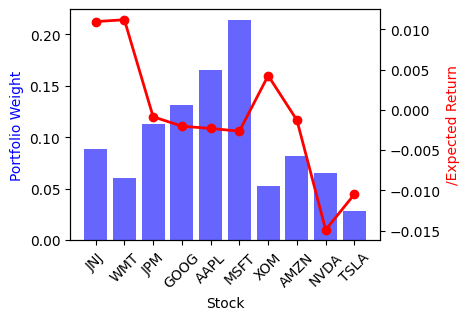

In [15]:
# 🔹 Bar Chart: Expected Return, Beta, and Portfolio Weight 🔹
fig, ax1 = plt.subplots(figsize=(4, 3))

# Plot Portfolio Weight (primary Y-axis)
ax1.bar(ranked_data["Stock"], ranked_data["Portfolio_Weight"], color="blue", alpha=0.6, label="Portfolio Weight")
ax1.set_ylabel("Portfolio Weight", color="blue")
ax1.set_xlabel("Stock")
ax1.set_xticklabels(ranked_data["Stock"], rotation=45)

# Plot Expected Return (secondary Y-axis)
ax2 = ax1.twinx()
ax2.plot(ranked_data["Stock"], ranked_data["Expected_Return"], color="red", marker="o", linestyle="-", linewidth=2, label="Expected Return")
ax2.set_ylabel("/Expected Return", color="red")

plt.savefig('Stock Ranks.png', dpi=300, bbox_inches='tight')
plt.show()